<a href="https://colab.research.google.com/github/abumazenhilles/CRM/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools


from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam ,RMSprop
# from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from pathlib import Path
import time

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
project_path = "gdrive/My Drive/brainTumor/"
orginal_dataset_path = f'{project_path}orginal_dataset/'
shutil.rmtree(f'{project_path}dataset')
Path(f"{project_path}dataset").mkdir(parents=True, exist_ok=True)

time.sleep(5)

Path(f"{project_path}dataset/test/yes").mkdir(parents=True)
Path(f"{project_path}dataset/test/no").mkdir(parents=True)
Path(f"{project_path}dataset/train/yes").mkdir(parents=True)
Path(f"{project_path}dataset/train/no").mkdir(parents=True)
Path(f"{project_path}dataset/val/yes").mkdir(parents=True)
Path(f"{project_path}dataset/val/no").mkdir(parents=True)
Path(f"{project_path}dataset/train_crop/yes").mkdir(parents=True)
Path(f"{project_path}dataset/train_crop/no").mkdir(parents=True)
Path(f"{project_path}dataset/test_crop/yes").mkdir(parents=True)
Path(f"{project_path}dataset/test_crop/no").mkdir(parents=True)
Path(f"{project_path}dataset/val_crop/yes").mkdir(parents=True)
Path(f"{project_path}dataset/val_crop/no").mkdir(parents=True)
Path(f"{project_path}dataset/preview").mkdir(parents=True)

# split the data by train/val/test
for CLASS in os.listdir(orginal_dataset_path):
    if not CLASS.startswith('.'):
        print(CLASS)
        img_folder_length = len(os.listdir(orginal_dataset_path + CLASS))
        print(img_folder_length)

        for (n, FILE_NAME) in enumerate(os.listdir(orginal_dataset_path + CLASS)):
            img = orginal_dataset_path + CLASS + '/' + FILE_NAME

            if n < 0.7*img_folder_length:
                shutil.copy(img, f'{project_path}dataset/train/' + CLASS+ '/' + FILE_NAME)
            else:
                shutil.copy(img, f'{project_path}dataset/test/'+ CLASS+ '/' + FILE_NAME)


Mounted at /content/gdrive
no
98
yes
155


In [ ]:

def load_data(dir_path, img_size=(100,100)):
    """
    Load resi
    \zed images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1

    X = np.array(X,dtype=object)
    y = np.array(y,dtype=np.float32)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:

TRAIN_DIR = f'{project_path}dataset/train/'
TEST_DIR = f'{project_path}dataset/test/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)


100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


178 images loaded from gdrive/My Drive/brainTumor/dataset/train/ directory.


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

75 images loaded from gdrive/My Drive/brainTumor/dataset/test/ directory.


In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[0],
    name='no',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[1],
    name='yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)


In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

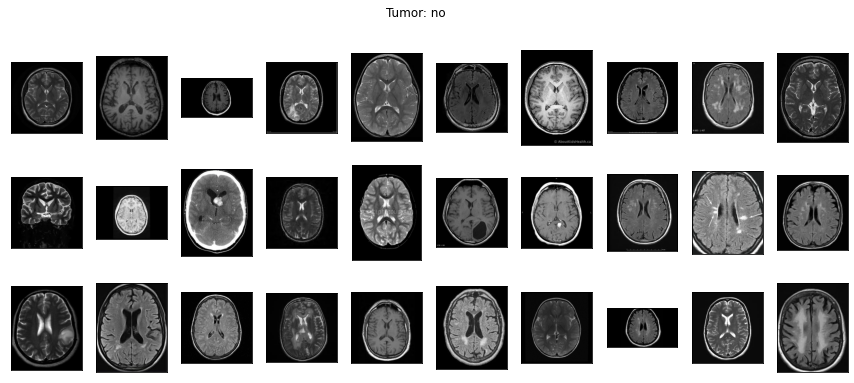

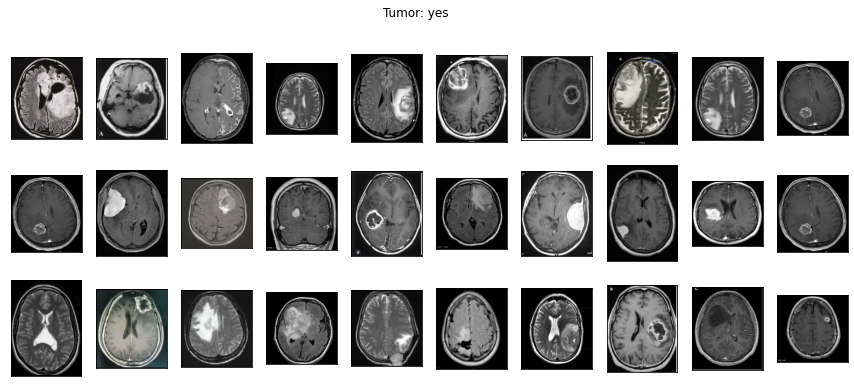

In [ ]:
plot_samples(X_train, y_train, labels, 30)


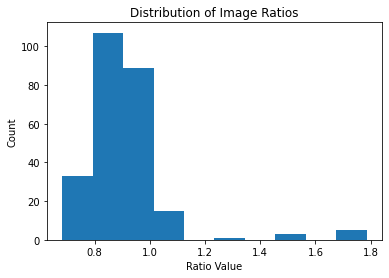

In [ ]:

RATIO_LIST = []
for set in (X_train, X_test):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()


In [ ]:

def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new,dtype=object)

In [ ]:

img = cv2.imread(f'{project_path}orginal_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


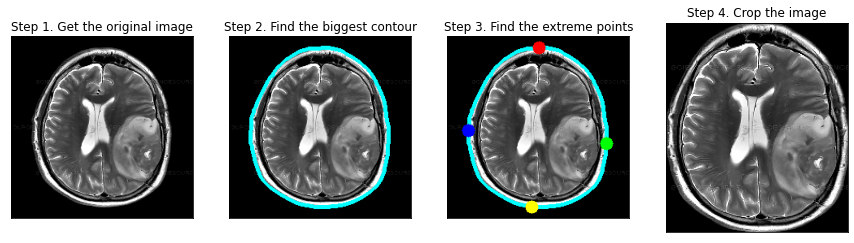

In [ ]:

plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_test_crop = crop_imgs(set_name=X_test)

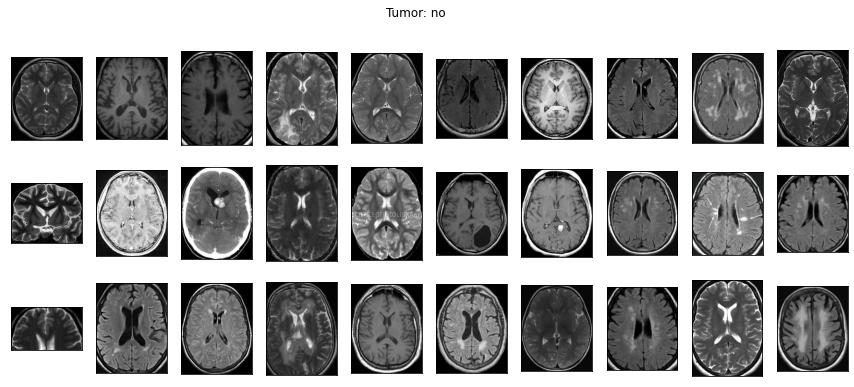

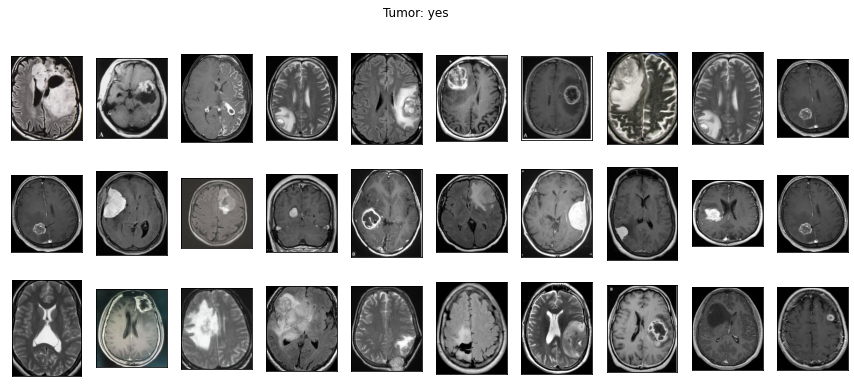

In [ ]:
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(f'{folder_name}/no/{i}.jpg', img)
        else:
            cv2.imwrite(f'{folder_name}/yes/{i}.jpg', img)
        i += 1


In [ ]:

save_new_images(X_train_crop, y_train, folder_name=f'{project_path}dataset/train_crop')
save_new_images(X_test_crop, y_test, folder_name=f'{project_path}dataset/test_crop')

In [ ]:

def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:

X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)

In [ ]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)


In [ ]:

x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir=f'{project_path}dataset/preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

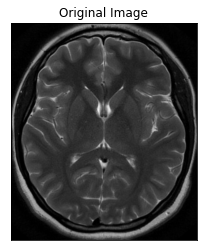

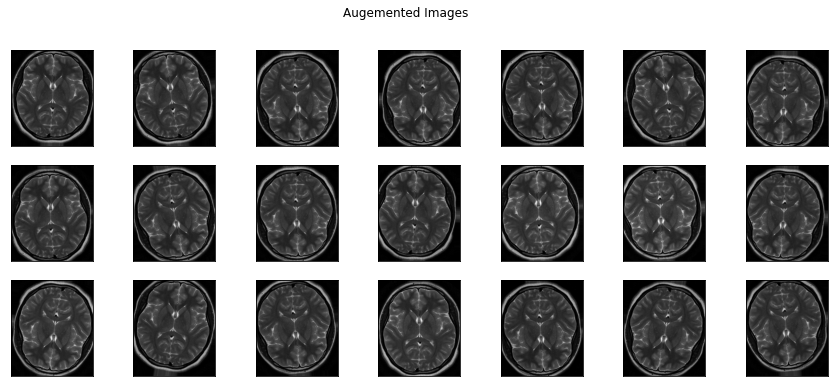

In [ ]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir(f'{project_path}dataset/preview'):
    img = cv2.cv2.imread(f'{project_path}dataset/preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
TRAIN_DIR = f'{project_path}dataset/train_crop'
TEST_DIR = f'{project_path}dataset/test_crop'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 178 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [ ]:

# load base model
vgg16_weight_path = f'{project_path}keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

In [ ]:

NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
    # evaluate the model
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
EPOCHS = 7
steps_per_epoch =(X_train_crop.size)//32
validation_steps=(X_test_crop.size)//16
print(steps_per_epoch)
print(validation_steps)

es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[es]
)

5
4
Epoch 1/7
5/5 [==============================] - 110s 23s/step - loss: 6.5232 - accuracy: 0.5274 - val_loss: 4.2117 - val_accuracy: 0.5000
Epoch 2/7
5/5 [==============================] - 108s 24s/step - loss: 5.2838 - accuracy: 0.5753 - val_loss: 2.0983 - val_accuracy: 0.5781
Epoch 3/7
5/5 [==============================] - 108s 23s/step - loss: 5.9371 - accuracy: 0.5274 - val_loss: 3.4617 - val_accuracy: 0.5625
Epoch 4/7
5/5 [==============================] - 108s 23s/step - loss: 3.3216 - accuracy: 0.6233 - val_loss: 1.9532 - val_accuracy: 0.6719
Epoch 5/7
5/5 [==============================] - 115s 24s/step - loss: 3.8778 - accuracy: 0.6187 - val_loss: 1.7713 - val_accuracy: 0.7031
Epoch 6/7
5/5 [==============================] - 108s 23s/step - loss: 3.6778 - accuracy: 0.6781 - val_loss: 2.4573 - val_accuracy: 0.6406
Epoch 7/7
5/5 [==============================] - 115s 24s/step - loss: 4.8349 - accuracy: 0.6438 - val_loss: 1.7075 - val_accuracy: 0.7188


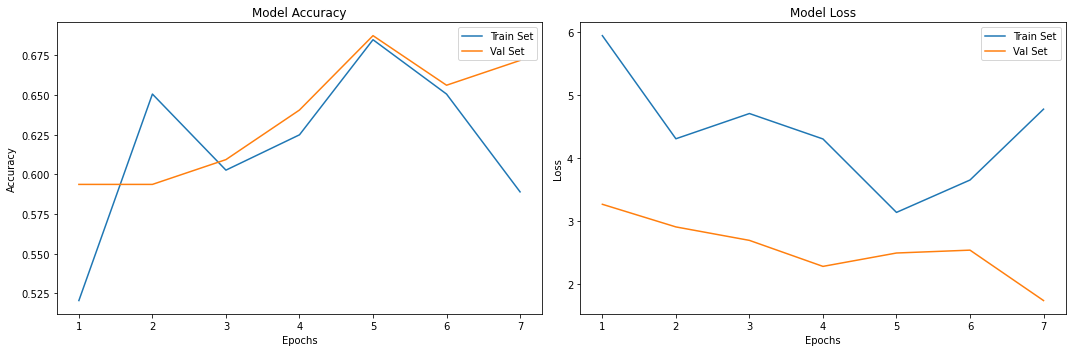

In [ ]:

# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
y_pred_bool = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred_bool)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

#%%

ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
        plt.show()

#%%

# save the model
model.save(f'{project_path}/2021-07-20_VGG_model.h5')


ValueError: ignored